In [38]:
import datetime as dt
from urllib.request import urlopen  
import bs4
import re
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')

# Data Crawling

In [2]:
# 크롤링 차단 장치 우회를 위해 웹사이트 호출 시 headers 값을 추가
import urllib.request
headers = {
    'User-Agent': 'Mozilla/5.0',
    'X-Requested-With': 'XMLHttpRequest',
}

## 구성종목 기본정보

In [3]:
'''
한국거래소 시가총액 상위 10종목 (2019년1월 기준)
005930	삼성전자
000660	SK하이닉스
068270	셀트리온
005380	현대차
207940	삼성바이오로직스
051910	LG화학
005490	POSCO
035420	NAVER
017670	SK텔레콤
015760	한국전력
'''
k10_component = ['005930', '000660', '068270', '005380', '207940',\
                 '051910', '005490', '035420', '017670', '015760']

In [4]:
# 구성종목 기본정보
# stock_cd = stock_code
def stock_info(stock_cd):
#     url_float = 'http://companyinfo.stock.naver.com/v1/company/c1010001.aspx?cmp_cd=' + stock_cd
    url_float = 'https://navercomp.wisereport.co.kr/v2/company/c1010001.aspx?cmp_cd=' + stock_cd
    source = urlopen(url_float).read()
    soup = bs4.BeautifulSoup(source, 'lxml')
    
    tmp = soup.find(id='cTB11').find_all('tr')[6].td.text
    tmp = tmp.replace('\r', '')
    tmp = tmp.replace('\n', '')
    tmp = tmp.replace('\t', '')
    
    tmp = re.split('/', tmp)

    # 발행주식 수
    outstanding = tmp[0].replace(',', '')
    outstanding = outstanding.replace('주', '')
    outstanding = outstanding.replace(' ', '')
    outstanding = int(outstanding)

    # 유동비율
    floating = tmp[1].replace(' ', '')
    floating = floating.replace('%', '')
    floating = float(floating)
    
    # 종목명
    name = soup.find(id='pArea').find('div').find('div').find('tr').find('td').find('span').text
    
    k10_outstanding[stock_cd] = outstanding
    k10_floating[stock_cd] = floating
    k10_name[stock_cd] = name

In [5]:
k10_outstanding = dict()
k10_floating = dict()
k10_name = dict()

for stock_cd in k10_component:
    stock_info(stock_cd)

In [6]:
k10_outstanding

{'005930': 5969782550,
 '000660': 728002365,
 '068270': 146390862,
 '005380': 211531506,
 '207940': 71174000,
 '051910': 70592343,
 '005490': 84571230,
 '035420': 164049085,
 '017670': 218833144,
 '015760': 641964077}

In [7]:
k10_floating

{'005930': 75.83,
 '000660': 73.86,
 '068270': 74.3,
 '005380': 65.26,
 '207940': 24.76,
 '051910': 66.63,
 '005490': 72.35,
 '035420': 83.3,
 '017670': 63.35,
 '015760': 46.08}

In [8]:
k10_name

{'005930': '삼성전자',
 '000660': 'SK하이닉스',
 '068270': '셀트리온',
 '005380': '현대차',
 '207940': '삼성바이오로직스',
 '051910': 'LG화학',
 '005490': 'POSCO홀딩스',
 '035420': 'NAVER',
 '017670': 'SK텔레콤',
 '015760': '한국전력'}

In [9]:
# 과거 시세만 반영
tmp = {'Outstanding' : k10_outstanding,\
       'Floating' : k10_floating,\
       'Name' : k10_name}
k10_info = pd.DataFrame(tmp)
k10_info

,Outstanding,Floating,Name
005930,5969782550,75.83,삼성전자
000660,728002365,73.86,SK하이닉스
068270,146390862,74.30,셀트리온
005380,211531506,65.26,현대차
207940,71174000,24.76,삼성바이오로직스
051910,70592343,66.63,LG화학
005490,84571230,72.35,POSCO홀딩스
035420,164049085,83.30,NAVER
017670,218833144,63.35,SK텔레콤
015760,641964077,46.08,한국전력


## 종목별 주가
* 2021-01-01 ~ 2021-03-01

In [10]:
def date_format(d):

    d = str(d)
    d = d.replace('/', '-')
    d = d.replace('.', '-')

    yyyy = int(d.split('-')[0])
    if yyyy < 50:
        yyyy = yyyy + 2000
    elif yyyy >=50 and yyyy < 100:
        yyyy = yyyy + 1900
    mm = int(d.split('-')[1])
    dd = int(d.split('-')[2])

    return dt.date(yyyy, mm, dd)

In [11]:
def historical_stock_naver(stock_cd, start_date='', end_date='', page_n=1, last_page=0):
    
    if start_date:
        start_date = date_format(start_date)
    else:
        start_date = dt.date.today()
    if end_date:
        end_date = date_format(end_date)
    else:
        end_date = dt.date.today()
        
    naver_stock = 'http://finance.naver.com/item/sise_day.nhn?code=' + stock_cd + '&page=' + str(page_n)
    
    # 기존 코드
    # source = urlopen(naver_stock).read()
    
    # 개정 코드 (1줄에서 2줄로 늘어남)
    url = urllib.request.Request(naver_stock, headers=headers)   # headers 정보 보내기
    source = urlopen(url).read()
    
    source = bs4.BeautifulSoup(source, 'lxml')
    
    dates = source.find_all('span', class_='tah p10 gray03')   # 날짜 수집   
    prices = source.find_all('td', class_='num')   # 종가 수집
    
    for n in range(len(dates)):
    
        if len(dates) > 0:
            
            # 날짜 처리
            this_date = dates[n].text
            this_date = date_format(this_date)
            
            if this_date <= end_date and this_date >= start_date:   
            # start_date와 end_date 사이에서 데이터 저장
                # 종가 처리
                this_close = prices[n*6].text
                this_close = this_close.replace(',', '')
                this_close = float(this_close)

                # 딕셔너리에 저장
                historical_prices[this_date] = this_close
                              
            elif this_date < start_date:   
            # start_date 이전이면 함수 종료
                return historical_prices              
            
    # 페이지 네비게이션
    if last_page == 0:
        last_page = source.find_all('table')[1].find('td', class_='pgRR').find('a')['href']
        last_page = last_page.split('&')[1]
        last_page = last_page.split('=')[1]
        last_page = float(last_page)
        
    # 다음 페이지 호출
    if page_n < last_page:
        page_n = page_n + 1
        historical_stock_naver(stock_cd, start_date, end_date, page_n, last_page)   
        
    return historical_prices  

In [12]:
k10_historical_prices = dict()

for stock_cd in k10_component:
    
    historical_prices = dict()
    start_date = '2021-01-01'   # 최신 날짜로 변경
    end_date = '2021-03-31'
    historical_prices = historical_stock_naver(stock_cd, start_date, end_date)
    
    k10_historical_prices[stock_cd] = historical_prices

In [13]:
k10_historical_price = pd.DataFrame(k10_historical_prices)
k10_historical_price.sort_index(axis=1, inplace=True)   # 컬럼 재정렬 (Python3.7 업데이트를 반영한 수정 패치)

In [14]:
k10_historical_price = k10_historical_price.fillna(method='ffill')
if k10_historical_price.isnull().values.any():
    k10_historical_price = k10_historical_price.fillna(method='bfill')
k10_historical_price.head(3)

,000660,005380,005490,005930,015760,017670,035420,051910,068270,207940
2021-03-31,132500.0,218000.0,320000.0,81400.0,23150.0,275000.0,377000.0,805000.0,324500.0,748000.0
2021-03-30,134500.0,219500.0,322500.0,82200.0,23250.0,268500.0,376500.0,808000.0,323500.0,747000.0
2021-03-29,132000.0,215500.0,327000.0,81600.0,23350.0,269000.0,372000.0,799000.0,330500.0,748000.0


In [15]:
k10_historical_price.sort_index(inplace=True)   # 데이터를 날짜순으로 정렬

In [16]:
k10_historical_price['005930'] = k10_historical_price['005930'] / 50   # 삼성전자 액면분할에 따른 수정주가 계산
k10_historical_price.head(3)

,000660,005380,005490,005930,015760,017670,035420,051910,068270,207940
2021-01-04,126000.0,207500.0,273000.0,1660.0,26900.0,237000.0,293000.0,889000.0,347500.0,829000.0
2021-01-05,130500.0,209500.0,285000.0,1678.0,26900.0,246000.0,292500.0,893000.0,354500.0,832000.0
2021-01-06,131000.0,203000.0,280000.0,1644.0,27150.0,250500.0,290000.0,890000.0,353500.0,817000.0


지수 산출을 위한 계산

In [17]:
#k10_historical_mc = 일별 시가총액(Market capitalization)
k10_historical_mc = k10_historical_price * k10_info['Outstanding'] * k10_info['Floating'] * 0.01
k10_historical_mc.tail(3)

,000660,005380,005490,005930,015760,017670,035420,051910,068270,207940
2021-03-29,7.097674e+13,2.974880e+13,2.000824e+13,7.387878e+12,6.907328e+12,3.729168e+13,5.083487e+13,3.758151e+13,3.594796e+13,1.318177e+13
2021-03-30,7.232099e+13,3.030098e+13,1.973290e+13,7.442201e+12,6.877746e+12,3.722237e+13,5.144981e+13,3.800483e+13,3.518658e+13,1.316414e+13
2021-03-31,7.124559e+13,3.009391e+13,1.957993e+13,7.369771e+12,6.848165e+12,3.812347e+13,5.151814e+13,3.786372e+13,3.529535e+13,1.318177e+13


In [18]:
k10 = pd.DataFrame()
k10['Market Cap'] = k10_historical_mc.sum(axis=1)
#k10.loc[dt.date.today()] = k10_info['f Market Cap'].sum()
k10.head(3)

,Market Cap
2021-01-04,2.956869e+14
2021-01-05,3.013802e+14
2021-01-06,3.001338e+14


In [19]:
# 기준시점
base_date = dt.date(2021, 1, 4)

In [20]:
k10['Market Cap'][base_date]

295686931452423.0

In [21]:
k10['Index'] = k10['Market Cap'] / k10['Market Cap'][base_date] * 100
k10.head(3)

,Market Cap,Index
2021-01-04,2.956869e+14,100.000000
2021-01-05,3.013802e+14,101.925423
2021-01-06,3.001338e+14,101.503913


## k200

In [22]:
def historical_index_naver(index_cd, start_date='', end_date='', page_n=1, last_page=0):
    
    if start_date:   # start_date가 있으면
        start_date = date_format(start_date)   # date 포맷으로 변환
    else:    # 없으면
        start_date = dt.date.today()   # 오늘 날짜를 지정
    if end_date:   
        end_date = date_format(end_date)   
    else:   
        end_date = dt.date.today()  
        
        
    naver_index = 'http://finance.naver.com/sise/sise_index_day.nhn?code=' + index_cd + '&page=' + str(page_n)
    
    # source = urlopen(naver_index).read()   # 지정한 페이지에서 코드 읽기
    
    url = urllib.request.Request(naver_index, headers=headers)   # headers 정보 보내기
    source = urlopen(url).read()
    
    source = bs4.BeautifulSoup(source, 'lxml')   # 뷰티풀 스프로 태그별로 코드 분류
    
    dates = source.find_all('td', class_='date')   # <td class="date">태그에서 날짜 수집   
    prices = source.find_all('td', class_='number_1')   # <td class="number_1">태그에서 지수 수집
    
    for n in range(len(dates)):
    
        if dates[n].text.split('.')[0].isdigit():
            
            # 날짜 처리
            this_date = dates[n].text
            this_date= date_format(this_date)
            
            if this_date <= end_date and this_date >= start_date:   
            # start_date와 end_date 사이에서 데이터 저장
                # 종가 처리
                this_close = prices[n*4].text   # prices 중 종가지수인 0,4,8,...번째 데이터 추출
                this_close = this_close.replace(',', '')
                this_close = float(this_close)

                # 딕셔너리에 저장
                historical_prices[this_date] = this_close
                
            elif this_date < start_date:   
            # start_date 이전이면 함수 종료
                return historical_prices              
            
    # 페이지 네비게이션
    if last_page == 0:
        last_page = source.find('td', class_='pgRR').find('a')['href']
        # 마지막페이지 주소 추출
        last_page = last_page.split('&')[1]   # & 뒤의 page=506 부분 추출
        last_page = last_page.split('=')[1]   # = 뒤의 페이지번호만 추출
        last_page = int(last_page)   # 숫자형 변수로 변환
        
    # 다음 페이지 호출
    if page_n < last_page:   
        page_n = page_n + 1   
        historical_index_naver(index_cd, start_date, end_date, page_n, last_page)   
        
    return historical_prices  

In [23]:
index_cd = 'KPI200'
historical_prices = dict()
kospi200 = historical_index_naver(index_cd, '2021-1-1', '2021-03-31')
k200 = pd.DataFrame({'Index' : kospi200})
k200.head(3)

,Index
2021-01-04,399.88
2021-01-05,406.03
2021-01-06,402.08


In [24]:
# 비교를 편하게 하기 위해 K10 지수를 KOSPI200과 맞춤 (기준일자 기준으로)
k10['Adj Index'] = k10['Market Cap'] / k10['Market Cap'][base_date] * k200['Index'][base_date] # index * k200 기준지수
k10.head(3)

,Market Cap,Index,Adj Index
2021-01-04,2.956869e+14,100.000000,399.880000
2021-01-05,3.013802e+14,101.925423,407.579381
2021-01-06,3.001338e+14,101.503913,405.893847


In [25]:
k10_info.info() # 기본정보

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 005930 to 015760
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Outstanding  10 non-null     int64  
 1   Floating     10 non-null     float64
 2   Name         10 non-null     object 
dtypes: float64(1), int64(1), object(1)
memory usage: 620.0+ bytes


In [26]:
k10.head()   # 전체시가총액, 지수  (일별)

,Market Cap,Index,Adj Index
2021-01-04,2.956869e+14,100.000000,399.880000
2021-01-05,3.013802e+14,101.925423,407.579381
2021-01-06,3.001338e+14,101.503913,405.893847
2021-01-07,3.096286e+14,104.715016,418.734406
2021-01-08,3.232383e+14,109.317749,437.139813


In [27]:
k10_historical_price.tail()   # 일별 주가

,000660,005380,005490,005930,015760,017670,035420,051910,068270,207940
2021-03-25,133000.0,218000.0,308500.0,1624.0,23100.0,253500.0,380000.0,788000.0,307500.0,718000.0
2021-03-26,135000.0,215500.0,318000.0,1630.0,23250.0,274000.0,383000.0,802000.0,314000.0,725000.0
2021-03-29,132000.0,215500.0,327000.0,1632.0,23350.0,269000.0,372000.0,799000.0,330500.0,748000.0
2021-03-30,134500.0,219500.0,322500.0,1644.0,23250.0,268500.0,376500.0,808000.0,323500.0,747000.0
2021-03-31,132500.0,218000.0,320000.0,1628.0,23150.0,275000.0,377000.0,805000.0,324500.0,748000.0


In [28]:
k10_historical_mc.head()     #  일별 시가총액

,000660,005380,005490,005930,015760,017670,035420,051910,068270,207940
2021-01-04,6.775052e+13,2.864443e+13,1.670413e+13,7.514631e+12,7.957479e+12,3.285550e+13,4.003930e+13,4.181472e+13,3.779702e+13,1.460920e+13
2021-01-05,7.017018e+13,2.892052e+13,1.743838e+13,7.596115e+12,7.957479e+12,3.410318e+13,3.997097e+13,4.200286e+13,3.855840e+13,1.466207e+13
2021-01-06,7.043903e+13,2.802323e+13,1.713244e+13,7.442201e+12,8.031433e+12,3.472701e+13,3.962934e+13,4.186175e+13,3.844963e+13,1.439773e+13
2021-01-07,7.232099e+13,2.843736e+13,1.780550e+13,7.505577e+12,8.001851e+12,3.743032e+13,3.956101e+13,4.524832e+13,3.888471e+13,1.443298e+13
2021-01-08,7.420295e+13,3.395918e+13,1.801966e+13,8.039750e+12,7.987060e+12,3.673716e+13,4.263570e+13,4.698864e+13,3.991801e+13,1.475019e+13


# 펀드 운용 모델★

In [29]:
import numpy as np

In [30]:
CU              = 50000 # 설정/환매단위
base_date       = dt.date(2021,1,4) # 설정 기준일, 2021-01-04
volume          = 1000000  # 최초설정수량
intereste_rate = 0.02   # 이자율

In [31]:
# 설정_환매
def creation_redemption(v):
    creation = np.random.randint(0,5)*CU   # 0~5사이의 임의의 정수
    if v >=500000:                          # 최소 50만좌 이상일 경우에만 환매 
        redemption = np.random.randint(0,5)*CU
    else:
        redemption = 0
    volume = v + creation - redemption     # 총좌수 = 보유좌수 + 설정 - 환매
    return(creation, redemption, volume)

## K10 stock_ratio

In [32]:
k10_stock_ratio = pd.DataFrame()

In [33]:
k10_stock_ratio = pd.DataFrame()
for s in k10_info.index:
    k10_stock_ratio[s] = k10_historical_mc[s]/k10_historical_mc.sum(axis=1)
k10_stock_ratio.head()    

,005930,000660,068270,005380,207940,051910,005490,035420,017670,015760
2021-01-04,0.025414,0.229129,0.127828,0.096874,0.049408,0.141416,0.056493,0.135411,0.111116,0.026912
2021-01-05,0.025204,0.232829,0.127939,0.095960,0.048650,0.139368,0.057862,0.132626,0.113157,0.026403
2021-01-06,0.024796,0.234692,0.128108,0.093369,0.047971,0.139477,0.057083,0.132039,0.115705,0.026760
2021-01-07,0.024241,0.233573,0.125585,0.091843,0.046614,0.146137,0.057506,0.127769,0.120888,0.025843
2021-01-08,0.024873,0.229561,0.123494,0.105059,0.045633,0.145368,0.055747,0.131902,0.113653,0.024710


In [34]:
# k10_historical_price.index

In [39]:
Fund_NAV = pd.DataFrame()  # Net Asset Value 순자산가치
Fund_Chg = pd.DataFrame()

for d in k10_historical_price.index:
    
    #포트폴리오 구성용 정보
    stock_price =  np.array(k10_historical_price.loc[d])
    stock_weight =  np.array(k10_stock_ratio.loc[d])
    
    
    
     # 주식 포트폴리오 NAV 계산
    if (d <=base_date):                                          # 기준일
        stock_holdings = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])  # 최초 주식 포트폴리오 (보유량 0)  
        NAV_cash = 0                                               # 최초 현금 보유량
    else:                                                        # 기준일 이후
        NAV_stock = sum(stock_holdings * stock_price)              # 주식 잔고
        NAV = NAV_stock + NAV_cash                                 # 전체 잔고
    
    
    # 기준가격 산정
    if (d == base_date):
        # 최초 기준가를 기준일자의 KOSPI 200 지수와 맞춤
        price = k200['Index'][base_date] * 100
    else:
        price = NAV / volume
              
        
    # 신규 펀드 설정/환매 좌수 계산
    if (d == base_date):
        volume =0
        volume_chg = 1000000     # 첫날 설정액
    else:
        vol = creation_redemption(volume)  # 설정/환매 함수 호출
        volume_chg = vol[0] - vol[1]
    # 총 펀드 좌수에 반영
    volume = volume + volume_chg
    # 펀드 입출금액
    aum_chg = price * volume_chg
    
    
    # 신규 주식 거래량 계산    
    stock_trade = np.floor( price * volume_chg * stock_weight / stock_price ) 
    # 주식 매매금액
    trade_amt = sum(stock_trade * stock_price)
    # 현금 잔고 변동 
    cash_chg = aum_chg - trade_amt
    
    
    # 총 주식 보유량 = 기 보유량 + 신규 거래량
    stock_holdings = stock_holdings + stock_trade
    # 현금 보유량 증가 (이자율 반영)
    cash_holdings  = np.floor( NAV_cash *np.exp( intereste_rate/365)  )
    

    #NAV 업데이트
    NAV_stock = sum(stock_holdings * stock_price)  
    NAV_cash  = cash_holdings + cash_chg
    NAV = NAV_stock + NAV_cash   
    
    date = pd.Series(d)
    
    # Fund NAV 정보를 DataFrame에 저장
    NAV_tmp = {'Stock' : NAV_stock, 'Cash' : NAV_cash, 'Total' : NAV, 'Price' : price}
    tmp = pd.DataFrame(NAV_tmp, index=date)
    Fund_NAV = Fund_NAV.append(tmp)
    

    # 일자별 설정&환매 좌수 정보를 DataFrame에 저장
    Chg_tmp = {'Amount Change' : aum_chg, 'Trade Amount' : trade_amt, 'Cash Change' : cash_chg}
    tmp = pd.DataFrame(Chg_tmp, index=date)
    Fund_Chg = Fund_Chg.append(tmp)
    

In [ ]:
if (d == base_date):
        volume = 0     # 펀드 좌수
        volume_chg = 1000000     # 첫날 설정액
    else:
        vol = creation_redemption(volume)     # 설정/환매 함수 호출, return -> (creation, redemption, volume)
        volume_chg = vol[0] - vol[1]          # volume_chg = creation - redemption

In [ ]:
for d in k10_historical_price.index[:10]:
    if (d == base_date):
        volume = 0     # 펀드 좌수
        volume_chg = 1000000  
    else:
        vol = creation_redemption(volume)     # 설정/환매 함수 호출
        volume_chg = vol[0] - vol[1]     
    print(vol )
    
#(creation, redemption, volume)

In [40]:
Fund_NAV.head()

,Stock,Cash,Total,Price
2021-01-04,3.998618e+10,1.815380e+06,3.998800e+10,39988.000000
2021-01-05,3.866890e+10,3.633446e+06,3.867253e+10,40707.927106
2021-01-06,3.627131e+10,6.265605e+06,3.627757e+10,40308.413092
2021-01-07,3.956556e+10,8.324081e+06,3.957388e+10,41656.719819
2021-01-08,3.535940e+10,9.369332e+06,3.536877e+10,44210.964169


In [41]:
Fund_Chg.head()

,Amount Change,Trade Amount,Cash Change
2021-01-04,3.998800e+10,3.998618e+10,1.815380e+06
2021-01-05,-2.035396e+09,-2.037214e+09,1.817967e+06
2021-01-06,-2.015421e+09,-2.018053e+09,2.631961e+06
2021-01-07,2.082836e+09,2.080778e+09,2.058133e+06
2021-01-08,-6.631645e+09,-6.632689e+09,1.044795e+06


# 수익률

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
# 그래프에서 한글 사용 세팅
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

In [48]:
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.7
plt.rcParams['lines.antialiased'] = True

## 펀드 VS 지수

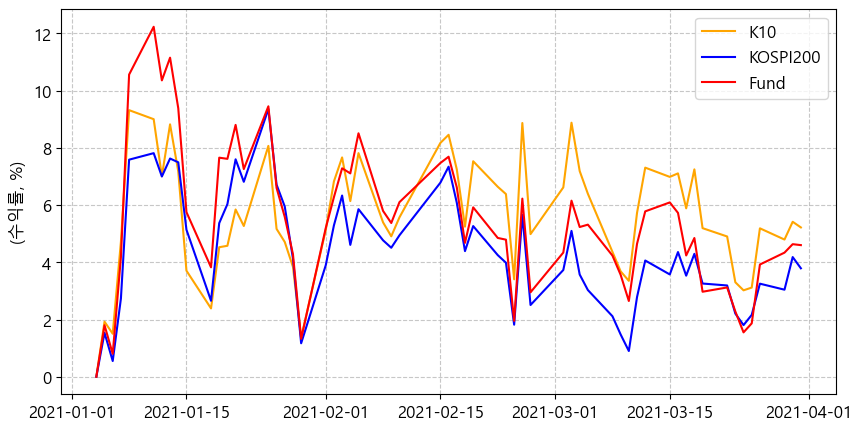

In [49]:
Earnings = pd.DataFrame()
Earnings['K10']      = ( k10['Index'] - k10['Index'][base_date] ) / k10['Index'][base_date]  *100
Earnings['KOSPI200'] = ( k200['Index'] - k200['Index'][base_date] ) / k200['Index'][base_date]  *100
Earnings['Fund'] = ( Fund_NAV['Price'] - Fund_NAV['Price'][base_date] )/ Fund_NAV['Price'][base_date] * 100
ax = Earnings.plot(color = ['orange', 'blue', 'red'])
ax.legend(loc=0)
ax.set_ylabel('(수익률, %)')
ax.grid(True)
# k10 지수가 더 수익이 좋은데????

## 펀드 기준가 vs 지수 

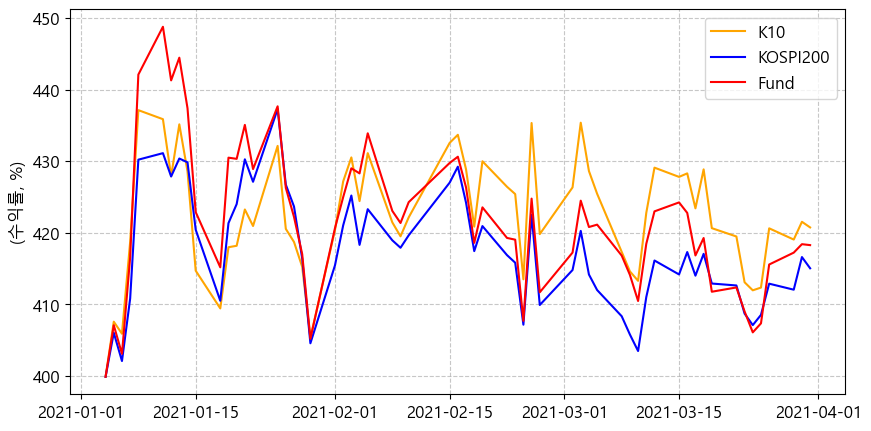

In [50]:
Indicator = pd.DataFrame()
Indicator['K10'] = k10['Adj Index']
Indicator['KOSPI200'] = k200['Index']
Indicator['Fund'] = Fund_NAV['Price']/100
ax = Indicator.plot(color = ['orange', 'blue', 'red'])
ax.legend(loc=0)
ax.set_ylabel('(수익률, %)')
ax.grid(True)

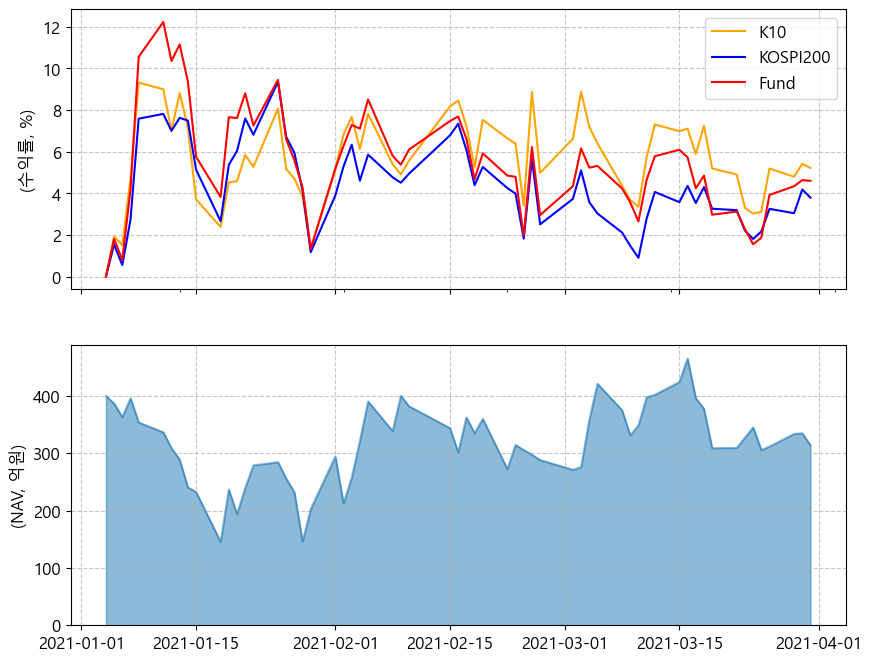

In [51]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
Earnings.plot.line(ax=ax1, color = ['orange', 'b', 'r'])                 # 수익률
ax1.set_ylabel('(수익률, %)')
Fund_NAV['Display'] = Fund_NAV['Total'] * 0.00000001                     # 순자산가치
Fund_NAV['Display'].plot.area(ax=ax2, stacked=False, sharex=True)
ax2.set_ylabel('(NAV, 억원)')
ax1.grid(True)
ax2.grid(True)

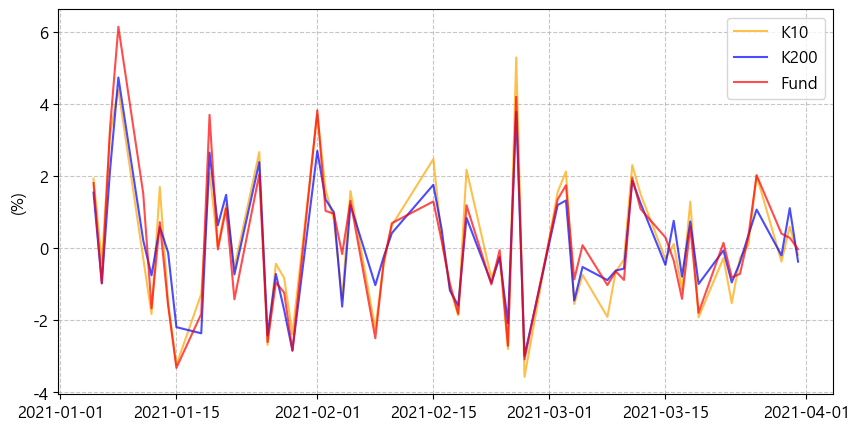

In [52]:
# 일간 수익률
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
Daily = pd.DataFrame()
Daily['K10'] = (k10['Index'] - k10['Index'].shift(1))\
                / k10['Index'].shift(1) * 100  
Daily['K200'] = (k200['Index'] - k200['Index'].shift(1))\
                / k200['Index'].shift(1) * 100
Daily['Fund'] = (Fund_NAV['Price'] - Fund_NAV['Price'].shift(1))\
                / Fund_NAV['Price'].shift(1) * 100  
Daily.plot(ax=ax, color = ['orange', 'blue', 'red'], alpha=0.7)
ax.set_ylabel('(%)')
ax.grid(True)

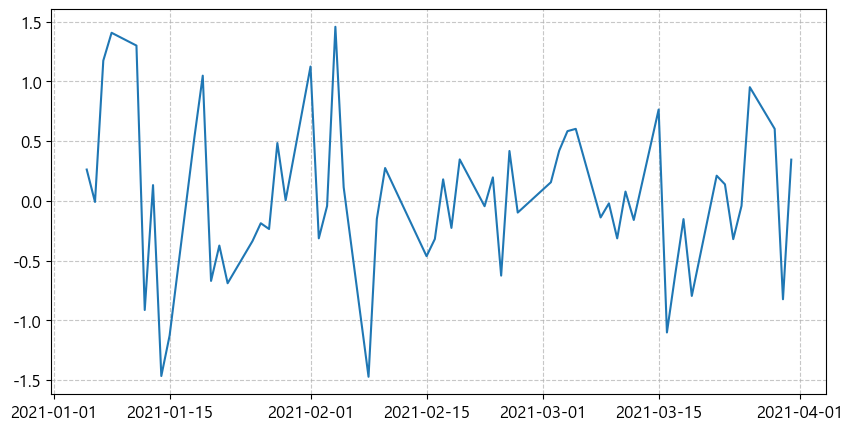

In [57]:
# KOSPI200 대비 일간 추적오차율 
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
Daily['TE200'] = Daily['Fund'] - Daily['K200']    # 추적오차율 = 펀드수익률 - 지수수익률
Daily['TE200'].plot(ax=ax)
ax.grid(True)

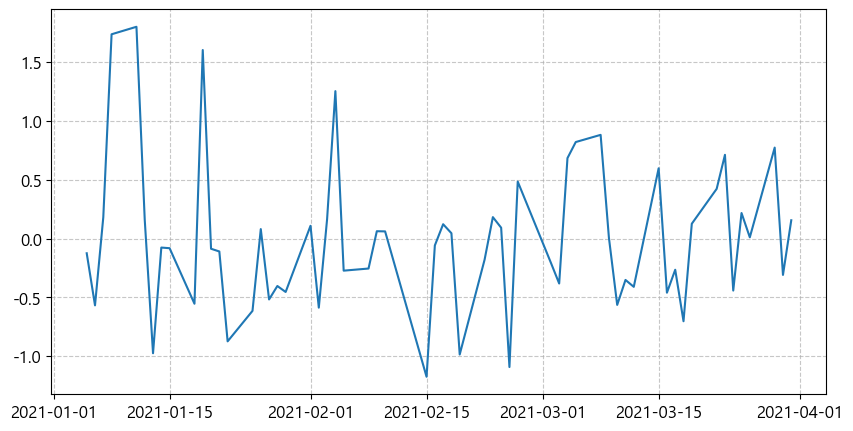

In [58]:
# K10 대비 일간 추적오차율 
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
Daily['TE10'] = Daily['Fund'] - Daily['K10']
Daily['TE10'].plot(ax=ax)
ax.grid(True)

In [56]:
Daily['K10'] = (k10['Index'] - k10['Index'].shift(1))\
            / k10['Index'].shift(1) * 100  
Daily.head()

#?? 이코드 이해가 안 돼애애애애

,K10,K200,Fund
2021-01-04,NaN,NaN,NaN
2021-01-05,1.925423,1.537961,1.800358
2021-01-06,-0.413547,-0.972835,-0.981416
2021-01-07,3.163526,2.171210,3.344976
2021-01-08,4.395485,4.724812,6.131650
